In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil

# launch your H2O cluster. H20 runs locally, unless you are connected to additional servers,
# and uses all CPUs, by default, to run its algos in parallel.
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.191-b12, mixed mode)
  Starting server from C:\Users\Aesha\PycharmProjects\INFO6105\NewEnv\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Aesha\AppData\Local\Temp\tmpne3qfew7
  JVM stdout: C:\Users\Aesha\AppData\Local\Temp\tmpne3qfew7\h2o_Aesha_started_from_python.out
  JVM stderr: C:\Users\Aesha\AppData\Local\Temp\tmpne3qfew7\h2o_Aesha_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,07 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,8 days
H2O cluster name:,H2O_from_python_Aesha_lmwooe
H2O cluster total nodes:,1
H2O cluster free memory:,2.646 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [4]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

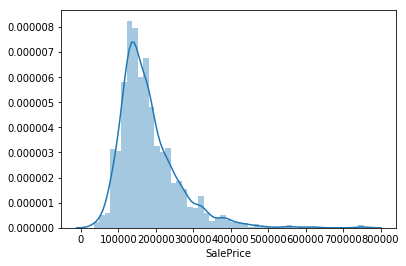

In [6]:
sns.distplot(df_train['SalePrice']);

In [7]:
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


In [8]:
combined_data = pd.concat([df_train, df_test], keys=['df_train', 'df_test'], sort=False)
combined_data.shape

(2919, 81)

In [9]:
combined_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,1460.000000
mean,1460.000000,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,...,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180921.195890
std,842.787043,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,...,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,730.500000,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129975.000000
50%,1460.000000,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,...,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,2189.500000,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [10]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2919 entries, (df_train, 0) to (df_test, 1458)
Data columns (total 81 columns):
Id               2919 non-null int64
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Ext

In [11]:
combined_data.drop('Id', axis = 1, inplace=True)

In [12]:
combined_data.shape

(2919, 80)

In [13]:
missing = combined_data.isnull().sum()/len(combined_data)
missing = missing[missing >0]
missing.sort_values(ascending=False, inplace=True)
missing

PoolQC          0.996574
MiscFeature     0.964029
Alley           0.932169
Fence           0.804385
SalePrice       0.499829
FireplaceQu     0.486468
LotFrontage     0.166495
GarageYrBlt     0.054471
GarageFinish    0.054471
GarageQual      0.054471
GarageCond      0.054471
GarageType      0.053786
BsmtCond        0.028092
BsmtExposure    0.028092
BsmtQual        0.027749
BsmtFinType2    0.027407
BsmtFinType1    0.027064
MasVnrType      0.008222
MasVnrArea      0.007879
MSZoning        0.001370
BsmtFullBath    0.000685
BsmtHalfBath    0.000685
Functional      0.000685
Utilities       0.000685
BsmtFinSF2      0.000343
BsmtUnfSF       0.000343
BsmtFinSF1      0.000343
TotalBsmtSF     0.000343
SaleType        0.000343
KitchenQual     0.000343
Exterior2nd     0.000343
Exterior1st     0.000343
GarageCars      0.000343
GarageArea      0.000343
Electrical      0.000343
dtype: float64

'PoolQC', 'MiscFeature', 'Alley', 'Fence' columns have more than 50% of the rows with missing values, hence they are being dropped from the combined data.

In [14]:
combined_data.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1, inplace=True)

In [15]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    combined_data[col] = combined_data[col].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    combined_data[col] = combined_data[col].fillna('None')

combined_data["MasVnrType"] = combined_data["MasVnrType"].fillna("None")
combined_data["MasVnrArea"] = combined_data["MasVnrArea"].fillna(0)

combined_data['MSZoning'] = combined_data['MSZoning'].fillna(combined_data['MSZoning'].mode()[0])

combined_data = combined_data.drop(['Utilities'], axis=1)

combined_data["Functional"] = combined_data["Functional"].fillna("Typ")

combined_data['Electrical'] = combined_data['Electrical'].fillna(combined_data['Electrical'].mode()[0])

combined_data['KitchenQual'] = combined_data['KitchenQual'].fillna(combined_data['KitchenQual'].mode()[0])

combined_data['Exterior1st'] = combined_data['Exterior1st'].fillna(combined_data['Exterior1st'].mode()[0])

combined_data['Exterior2nd'] = combined_data['Exterior2nd'].fillna(combined_data['Exterior2nd'].mode()[0])

combined_data["FireplaceQu"] = combined_data["FireplaceQu"].fillna("None")

combined_data['SaleType'] = combined_data['SaleType'].fillna(combined_data['SaleType'].mode()[0])

combined_data['MSSubClass'] = combined_data['MSSubClass'].fillna("None")

combined_data["LotFrontage"] = combined_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [16]:
combined_data['SalePrice'] = np.log1p(combined_data["SalePrice"])

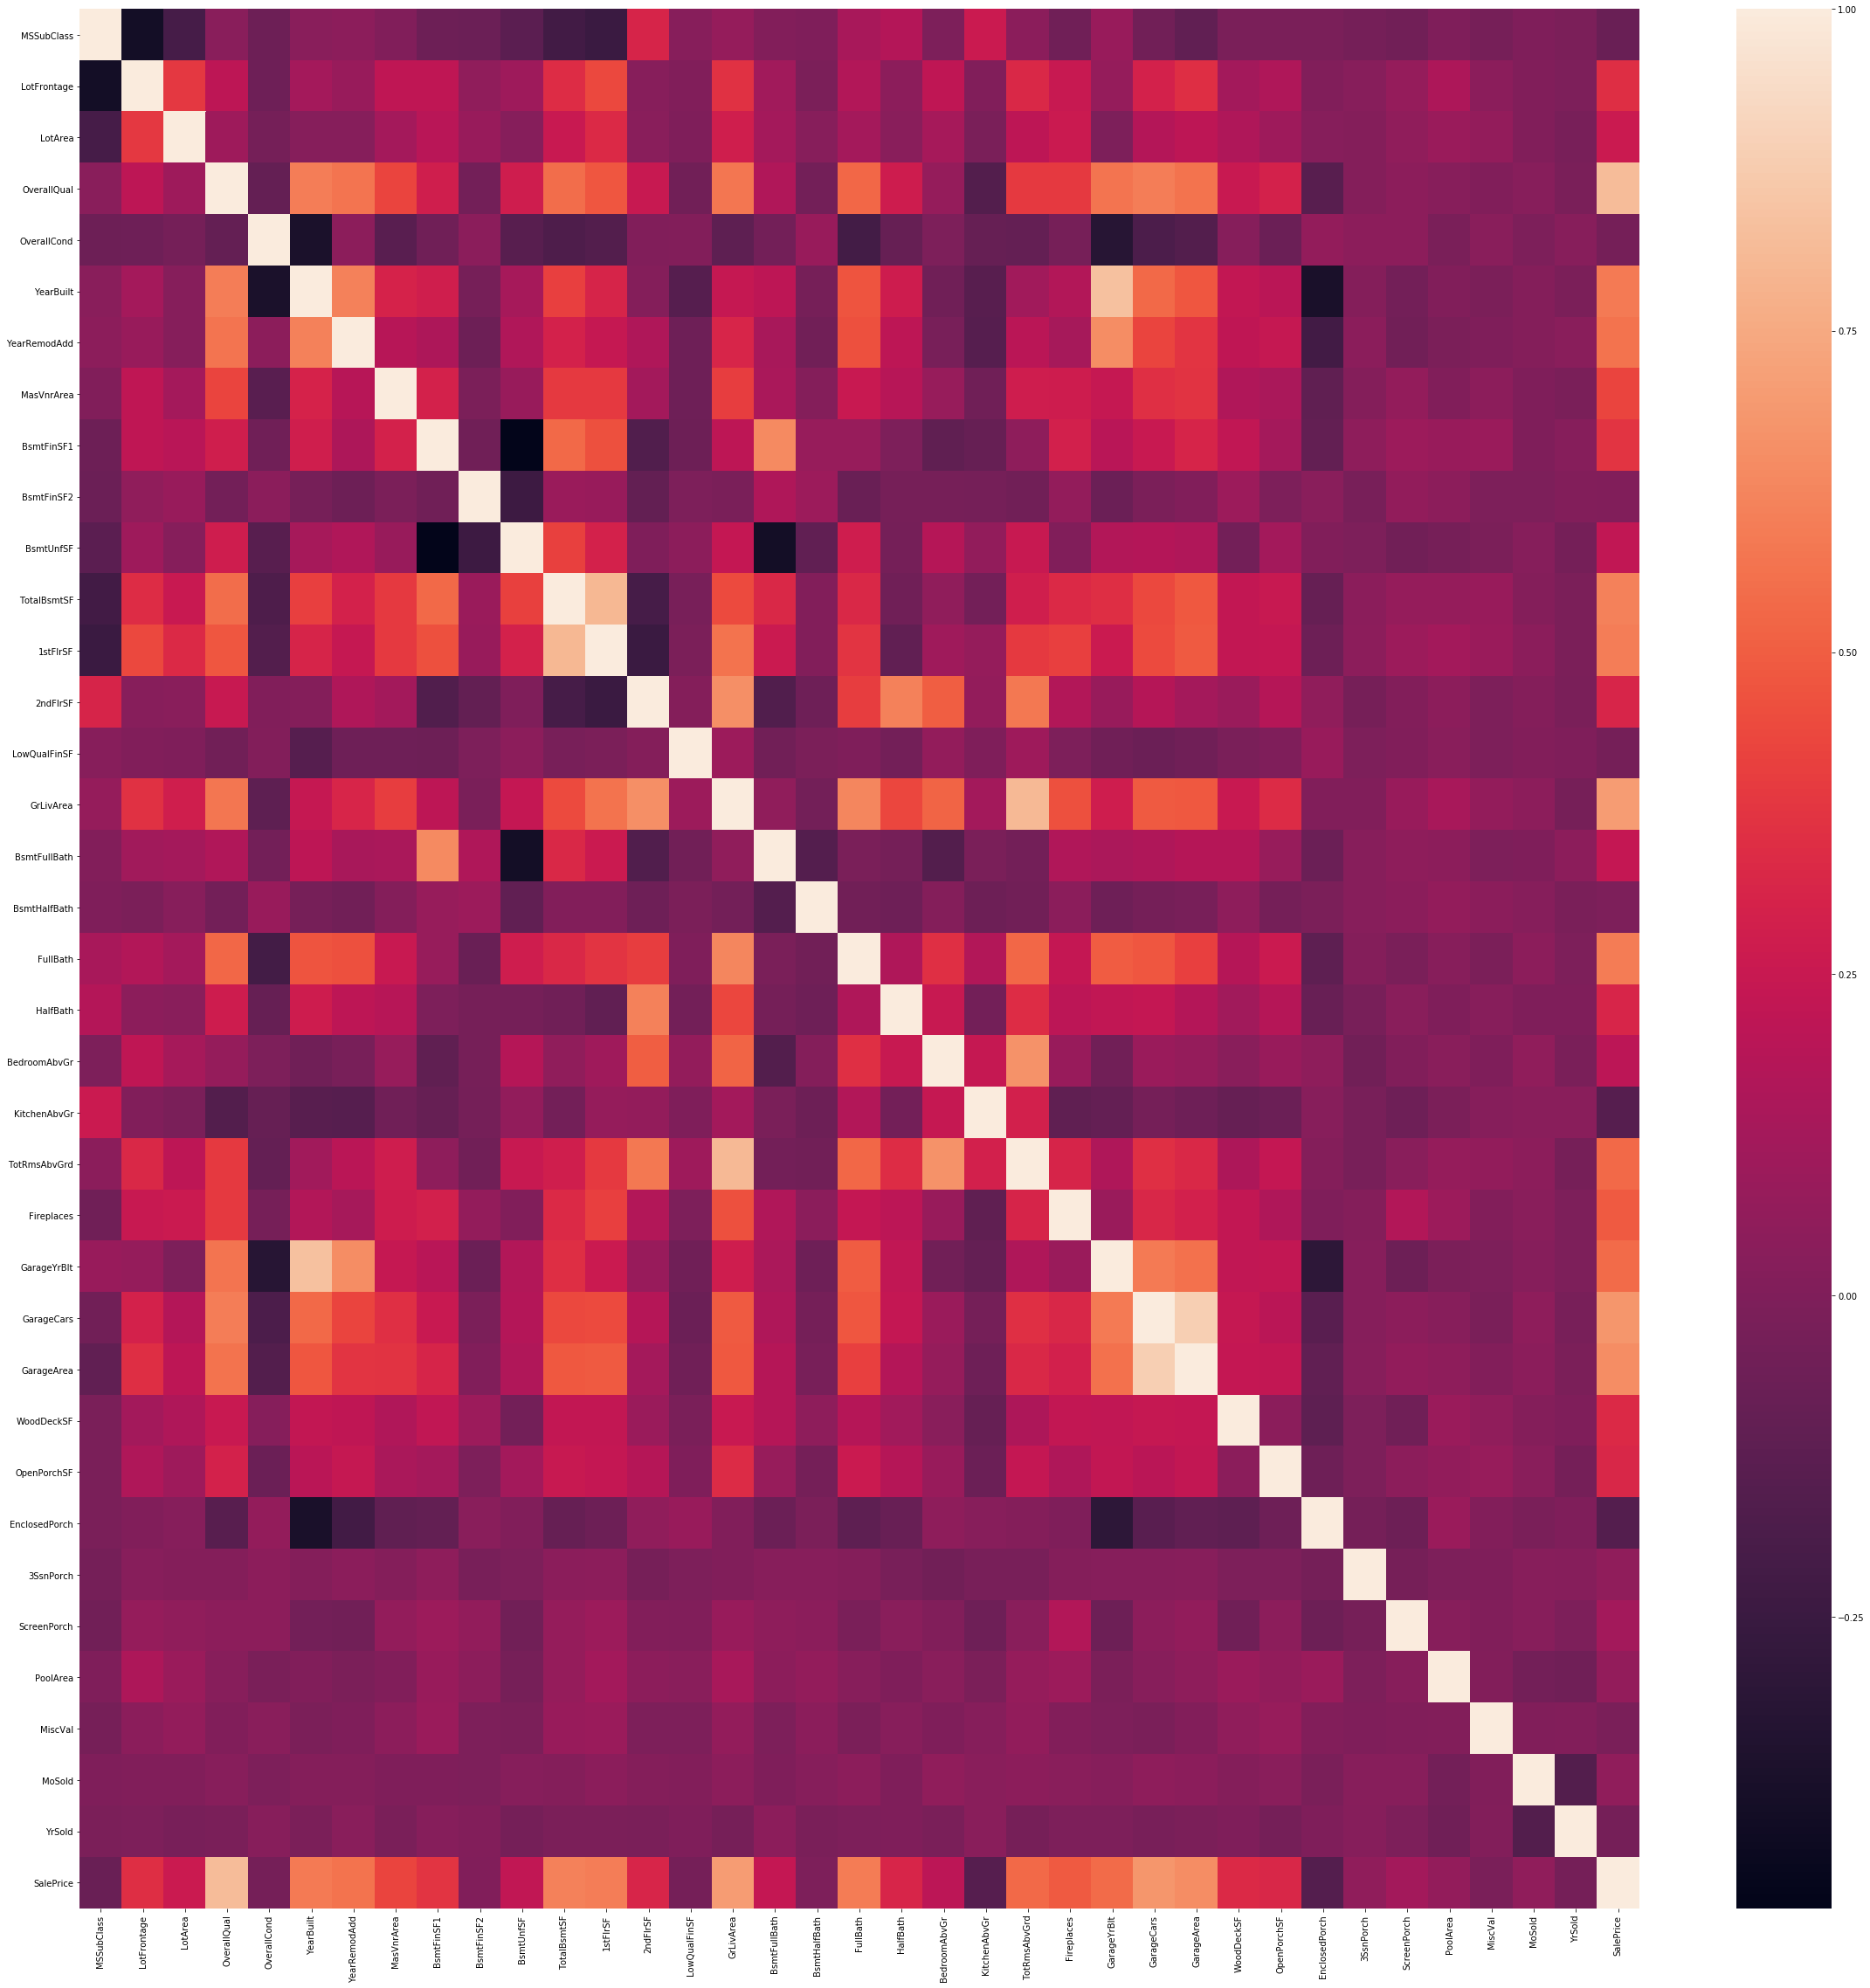

In [17]:
corr = combined_data.corr()
f, ax = plt.subplots(figsize=(40, 40))
sns.heatmap(corr)

Correlation Matrix Heatmap Inference: SalePrice has high correlation with OverallQual, GrLivArea, GarageCars, GarageArea.

In order to get a better view of the heatmap, we are overviewing the above heatmap and extracting the variables with the a good correlation with the target variable that is the SalePrice judging from the color of the correlation matrix

OverAll Qualification, Year Built, Total RMS Above Ground, Total Basement SF, 1st FlR SF, Grn Livi Area, Full Bath, Garage Cars, Garage Areas have a good positive correlation with SalePrice.

In [18]:
combined_data.drop(['MSSubClass', 'OverallCond', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', '2ndFlrSF', 'BsmtFullBath',
                  'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
                  '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'], axis=1, inplace=True)

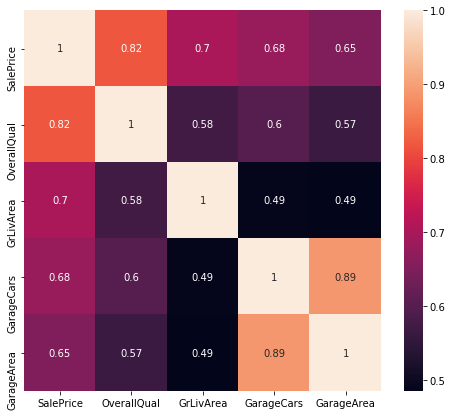

In [19]:
corr1 = combined_data[['SalePrice','OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea']].corr()
f, ax = plt.subplots(figsize=(8,7))
sns.heatmap(corr1, annot=True)

k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [20]:
combined_data.shape

(2919, 55)

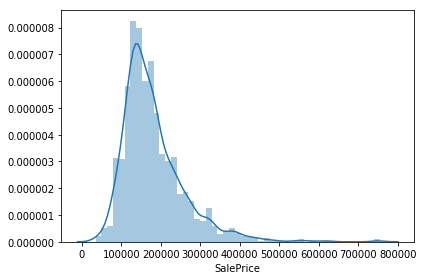

In [21]:
sns.distplot(df_train['SalePrice'])
plt.tight_layout()
plt.show()

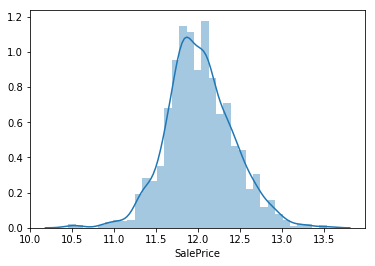

In [22]:
target = np.log(df_train['SalePrice'])
sns.distplot(target)
plt.show()

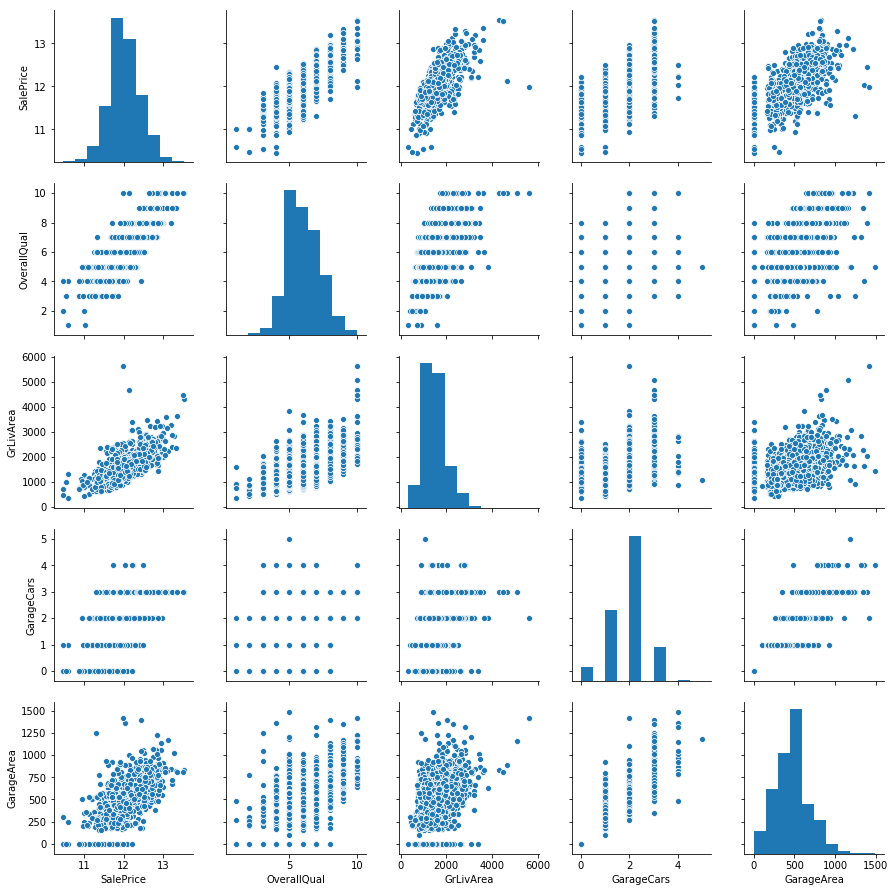

In [23]:
ax = sns.pairplot(combined_data[['SalePrice','OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea']])

In [24]:
labels = df_train['SalePrice']

In [25]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    combined_data[col] = combined_data[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    combined_data[col] = combined_data[col].fillna(0)

In [26]:
missing = combined_data.isnull().sum()/len(combined_data)
missing = missing[missing >0]
missing.sort_values(ascending=False, inplace=True)
missing

SalePrice    0.499829
dtype: float64

In [27]:
combined_data.head(5)

MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
df_train 0       RL         65.0     8450   Pave      Reg         Lvl   
         1       RL         80.0     9600   Pave      Reg         Lvl   
         2       RL         68.0    11250   Pave      IR1         Lvl   
         3       RL         60.0     9550   Pave      IR1         Lvl   
         4       RL         84.0    14260   Pave      IR1         Lvl   

           LotConfig LandSlope Neighborhood Condition1  ... GarageYrBlt  \
df_train 0    Inside       Gtl      CollgCr       Norm  ...      2003.0   
         1       FR2       Gtl      Veenker      Feedr  ...      1976.0   
         2    Inside       Gtl      CollgCr       Norm  ...      2001.0   
         3    Corner       Gtl      Crawfor       Norm  ...      1998.0   
         4       FR2       Gtl      NoRidge       Norm  ...      2000.0   

           GarageFinish GarageCars  GarageArea  GarageQual  GarageCond  \
df_train 0          RFn        2.0       548.0          TA          TA   
         1          RFn        2.0       460.0          TA          TA   
         2          RFn        2.0       608.0          TA          TA   
         3          Unf        3.0       642.0          TA          TA   
         4          RFn        3.0       836.0          TA          TA   

           PavedDrive SaleType SaleCondition  SalePrice  
df_train 0          Y       WD        Normal  12.247699  
         1          Y       WD        Normal  12.109016  
         2          Y       WD        Normal  12.317171  
         3          Y       WD       Abnorml  11.849405  
         4          Y       WD        Normal  12.429220  

[5 rows x 55 columns]

In [28]:
#Try adding the prefix term for each variable
combined_data2 = pd.get_dummies(combined_data, drop_first=True)

In [29]:
combined_data2.shape

(2919, 226)

In [30]:
combined_data2.head(5)

LotFrontage  LotArea  OverallQual  YearBuilt  YearRemodAdd  \
df_train 0         65.0     8450            7       2003          2003   
         1         80.0     9600            6       1976          1976   
         2         68.0    11250            7       2001          2002   
         3         60.0     9550            7       1915          1970   
         4         84.0    14260            8       2000          2000   

            MasVnrArea  BsmtFinSF1  TotalBsmtSF  1stFlrSF  GrLivArea  ...  \
df_train 0       196.0       706.0        856.0       856       1710  ...   
         1         0.0       978.0       1262.0      1262       1262  ...   
         2       162.0       486.0        920.0       920       1786  ...   
         3         0.0       216.0        756.0       961       1717  ...   
         4       350.0       655.0       1145.0      1145       2198  ...   

            SaleType_ConLI  SaleType_ConLw  SaleType_New  SaleType_Oth  \
df_train 0               0               0             0             0   
         1               0               0             0             0   
         2               0               0             0             0   
         3               0               0             0             0   
         4               0               0             0             0   

            SaleType_WD  SaleCondition_AdjLand  SaleCondition_Alloca  \
df_train 0            1                      0                     0   
         1            1                      0                     0   
         2            1                      0                     0   
         3            1                      0                     0   
         4            1                      0                     0   

            SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
df_train 0                     0                     1                      0  
         1                     0                     1                      0  
         2                     0                     1                      0  
         3                     0                     0                      0  
         4                     0                     1                      0  

[5 rows x 226 columns]

In [31]:
train = combined_data2.loc['df_train']

In [32]:
test = combined_data2.loc['df_test']

In [33]:
test.drop('SalePrice', axis=1, inplace=True)

In [34]:
missing = train.isnull().sum()/len(train)
missing = missing[missing >0]
missing.sort_values(ascending=False, inplace=True)
missing

Series([], dtype: float64)

In [35]:
missing = test.isnull().sum()/len(test)
missing = missing[missing >0]
missing.sort_values(ascending=False, inplace=True)
missing

Series([], dtype: float64)

In [36]:
train.shape

(1460, 226)

In [37]:
test.shape

(1459, 225)

In [38]:
train.columns.values

array(['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF',
       '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'SalePrice',
       'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM',
       'Street_Pave', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg',
       'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl',
       'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3',
       'LotConfig_Inside', 'LandSlope_Mod', 'LandSlope_Sev',
       'Neighborhood_Blueste', 'Neighborhood_BrDale',
       'Neighborhood_BrkSide', 'Neighborhood_ClearCr',
       'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_Gilbert',
       'Neighborhood_IDOTRR', 'Neighborhood_MeadowV',
       'Neighborhood_Mitchel', 'Neighborhood_NAmes',
       'Neighborhood_NPkVill', 'Neighborhood_NWAmes',
       'Neighborhood_NoRidge', '

In [39]:
test.columns.values

array(['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF',
       '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'MSZoning_FV',
       'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Pave',
       'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_HLS',
       'LandContour_Low', 'LandContour_Lvl', 'LotConfig_CulDSac',
       'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside',
       'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blueste',
       'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards',
       'Neighborhood_Gilbert', 'Neighborhood_IDOTRR',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel',
       'Neighborhood_NAmes', 'Neighborhood_NPkVill',
       'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_

In [40]:
print(train.shape)
print(test.shape)

(1460, 226)
(1459, 225)


In [41]:
header_train = ['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF',
       '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'SalePrice',
       'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM',
       'Street_Pave', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg',
       'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl',
       'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3',
       'LotConfig_Inside', 'LandSlope_Mod', 'LandSlope_Sev',
       'Neighborhood_Blueste', 'Neighborhood_BrDale',
       'Neighborhood_BrkSide', 'Neighborhood_ClearCr',
       'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_Gilbert',
       'Neighborhood_IDOTRR', 'Neighborhood_MeadowV',
       'Neighborhood_Mitchel', 'Neighborhood_NAmes',
       'Neighborhood_NPkVill', 'Neighborhood_NWAmes',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_OldTown', 'Neighborhood_SWISU',
       'Neighborhood_Sawyer', 'Neighborhood_SawyerW',
       'Neighborhood_Somerst', 'Neighborhood_StoneBr',
       'Neighborhood_Timber', 'Neighborhood_Veenker', 'Condition1_Feedr',
       'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN',
       'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe',
       'Condition1_RRNn', 'Condition2_Feedr', 'Condition2_Norm',
       'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe',
       'Condition2_RRAn', 'Condition2_RRNn', 'BldgType_2fmCon',
       'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE',
       'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Fin',
       'HouseStyle_2.5Unf', 'HouseStyle_2Story', 'HouseStyle_SFoyer',
       'HouseStyle_SLvl', 'RoofStyle_Gable', 'RoofStyle_Gambrel',
       'RoofStyle_Hip', 'RoofStyle_Mansard', 'RoofStyle_Shed',
       'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal',
       'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake',
       'RoofMatl_WdShngl', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm',
       'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd',
       'Exterior1st_HdBoard', 'Exterior1st_ImStucc',
       'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stone',
       'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng',
       'Exterior1st_WdShing', 'Exterior2nd_AsphShn',
       'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', 'Exterior2nd_CBlock',
       'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard',
       'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd', 'Exterior2nd_Other',
       'Exterior2nd_Plywood', 'Exterior2nd_Stone', 'Exterior2nd_Stucco',
       'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng',
       'Exterior2nd_Wd Shng', 'MasVnrType_BrkFace', 'MasVnrType_None',
       'MasVnrType_Stone', 'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA',
       'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_Po', 'ExterCond_TA',
       'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab',
       'Foundation_Stone', 'Foundation_Wood', 'BsmtQual_Fa',
       'BsmtQual_Gd', 'BsmtQual_None', 'BsmtQual_TA', 'BsmtCond_Gd',
       'BsmtCond_None', 'BsmtCond_Po', 'BsmtCond_TA', 'BsmtExposure_Gd',
       'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtExposure_None',
       'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ',
       'BsmtFinType1_None', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf',
       'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ', 'BsmtFinType2_LwQ',
       'BsmtFinType2_None', 'BsmtFinType2_Rec', 'BsmtFinType2_Unf',
       'Heating_GasA', 'Heating_GasW', 'Heating_Grav', 'Heating_OthW',
       'Heating_Wall', 'HeatingQC_Fa', 'HeatingQC_Gd', 'HeatingQC_Po',
       'HeatingQC_TA', 'CentralAir_Y', 'Electrical_FuseF',
       'Electrical_FuseP', 'Electrical_Mix', 'Electrical_SBrkr',
       'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA',
       'Functional_Maj2', 'Functional_Min1', 'Functional_Min2',
       'Functional_Mod', 'Functional_Sev', 'Functional_Typ',
       'FireplaceQu_Fa', 'FireplaceQu_Gd', 'FireplaceQu_None',
       'FireplaceQu_Po', 'FireplaceQu_TA', 'GarageType_Attchd',
       'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_CarPort',
       'GarageType_Detchd', 'GarageType_None', 'GarageFinish_None',
       'GarageFinish_RFn', 'GarageFinish_Unf', 'GarageQual_Fa',
       'GarageQual_Gd', 'GarageQual_None', 'GarageQual_Po',
       'GarageQual_TA', 'GarageCond_Fa', 'GarageCond_Gd',
       'GarageCond_None', 'GarageCond_Po', 'GarageCond_TA',
       'PavedDrive_P', 'PavedDrive_Y', 'SaleType_CWD', 'SaleType_Con',
       'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw',
       'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial']

In [42]:
header_test = ['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF',
       '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'MSZoning_FV',
       'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Pave',
       'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_HLS',
       'LandContour_Low', 'LandContour_Lvl', 'LotConfig_CulDSac',
       'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside',
       'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blueste',
       'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards',
       'Neighborhood_Gilbert', 'Neighborhood_IDOTRR',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel',
       'Neighborhood_NAmes', 'Neighborhood_NPkVill',
       'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_SWISU', 'Neighborhood_Sawyer',
       'Neighborhood_SawyerW', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Timber',
       'Neighborhood_Veenker', 'Condition1_Feedr', 'Condition1_Norm',
       'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe',
       'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn',
       'Condition2_Feedr', 'Condition2_Norm', 'Condition2_PosA',
       'Condition2_PosN', 'Condition2_RRAe', 'Condition2_RRAn',
       'Condition2_RRNn', 'BldgType_2fmCon', 'BldgType_Duplex',
       'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1.5Unf',
       'HouseStyle_1Story', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf',
       'HouseStyle_2Story', 'HouseStyle_SFoyer', 'HouseStyle_SLvl',
       'RoofStyle_Gable', 'RoofStyle_Gambrel', 'RoofStyle_Hip',
       'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_CompShg',
       'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll',
       'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl',
       'Exterior1st_AsphShn', 'Exterior1st_BrkComm',
       'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd',
       'Exterior1st_HdBoard', 'Exterior1st_ImStucc',
       'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stone',
       'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng',
       'Exterior1st_WdShing', 'Exterior2nd_AsphShn',
       'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', 'Exterior2nd_CBlock',
       'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard',
       'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd', 'Exterior2nd_Other',
       'Exterior2nd_Plywood', 'Exterior2nd_Stone', 'Exterior2nd_Stucco',
       'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng',
       'Exterior2nd_Wd Shng', 'MasVnrType_BrkFace', 'MasVnrType_None',
       'MasVnrType_Stone', 'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA',
       'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_Po', 'ExterCond_TA',
       'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab',
       'Foundation_Stone', 'Foundation_Wood', 'BsmtQual_Fa',
       'BsmtQual_Gd', 'BsmtQual_None', 'BsmtQual_TA', 'BsmtCond_Gd',
       'BsmtCond_None', 'BsmtCond_Po', 'BsmtCond_TA', 'BsmtExposure_Gd',
       'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtExposure_None',
       'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ',
       'BsmtFinType1_None', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf',
       'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ', 'BsmtFinType2_LwQ',
       'BsmtFinType2_None', 'BsmtFinType2_Rec', 'BsmtFinType2_Unf',
       'Heating_GasA', 'Heating_GasW', 'Heating_Grav', 'Heating_OthW',
       'Heating_Wall', 'HeatingQC_Fa', 'HeatingQC_Gd', 'HeatingQC_Po',
       'HeatingQC_TA', 'CentralAir_Y', 'Electrical_FuseF',
       'Electrical_FuseP', 'Electrical_Mix', 'Electrical_SBrkr',
       'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA',
       'Functional_Maj2', 'Functional_Min1', 'Functional_Min2',
       'Functional_Mod', 'Functional_Sev', 'Functional_Typ',
       'FireplaceQu_Fa', 'FireplaceQu_Gd', 'FireplaceQu_None',
       'FireplaceQu_Po', 'FireplaceQu_TA', 'GarageType_Attchd',
       'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_CarPort',
       'GarageType_Detchd', 'GarageType_None', 'GarageFinish_None',
       'GarageFinish_RFn', 'GarageFinish_Unf', 'GarageQual_Fa',
       'GarageQual_Gd', 'GarageQual_None', 'GarageQual_Po',
       'GarageQual_TA', 'GarageCond_Fa', 'GarageCond_Gd',
       'GarageCond_None', 'GarageCond_Po', 'GarageCond_TA',
       'PavedDrive_P', 'PavedDrive_Y', 'SaleType_CWD', 'SaleType_Con',
       'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw',
       'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial']

In [43]:
training = pd.DataFrame(train)
testing = pd.DataFrame(test)
training.to_csv('training data.csv', columns = header_train, index=False)
testing.to_csv('testing data.csv', columns = header_test, index=False)

In [44]:
training = h2o.import_file("training data.csv")
testing = h2o.import_file("testing data.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [45]:
target='SalePrice' 
data_file='training'
run_id='SOME_ID_20190407_221529' # Just some arbitrary ID
server_path='./Users/apurvasalvi/Desktop/Spring\ 2019/Git\ Repository/hyperparameter-db-project-ds06/.'
classification=True
scale=False
max_models=None
balance_y=False # balance_classes=balance_y
balance_threshold=0.2
project ="automl_test"  # project_name = project

In [46]:
# assign target and inputs for logistic regression
y = target
X = [name for name in training.columns if name != y]
print(y)
print(X)

SalePrice
['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Pave', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neig

In [47]:
import os

data_path=os.path.join(server_path,data_file)
data_path

'./Users/apurvasalvi/Desktop/Spring\\ 2019/Git\\ Repository/hyperparameter-db-project-ds06/.\\training'

In [48]:
aml_500 = H2OAutoML(max_runtime_secs=500,project_name = project) # init automl, run for 300 seconds
aml_500.train(x=X,  
           y=y,
           training_frame=training)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [49]:
leaderboard = aml_500.leaderboard
leaderboard.head(40)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20190409_000548,0.0180265,0.134263,0.0180265,0.0885301,0.0103886
StackedEnsemble_BestOfFamily_AutoML_20190409_000548,0.018432,0.135765,0.018432,0.0897098,0.0105019
GBM_grid_1_AutoML_20190409_000548_model_2,0.0187889,0.137073,0.0187889,0.0933018,0.0106417
GBM_3_AutoML_20190409_000548,0.019311,0.138964,0.019311,0.0934208,0.0107574
GBM_2_AutoML_20190409_000548,0.0195077,0.13967,0.0195077,0.0929692,0.0108061
GBM_4_AutoML_20190409_000548,0.0196915,0.140327,0.0196915,0.0926678,0.0108735
GBM_1_AutoML_20190409_000548,0.0203078,0.142506,0.0203078,0.0954669,0.0110484
XRT_1_AutoML_20190409_000548,0.0212269,0.145694,0.0212269,0.0956934,0.0113005
DRF_1_AutoML_20190409_000548,0.0213566,0.146139,0.0213566,0.0971343,0.0113356
GBM_grid_1_AutoML_20190409_000548_model_1,0.0226907,0.150634,0.0226907,0.103346,0.0116875


In [57]:
aml_500leaderboard_df=aml_500.leaderboard.as_data_frame()
model_set=aml_500leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[3])

In [58]:
mod_best.params

{'balance_classes': {'actual': False, 'default': False},
 'build_tree_one_node': {'actual': False, 'default': False},
 'calibrate_model': {'actual': False, 'default': False},
 'calibration_frame': {'actual': None, 'default': None},
 'categorical_encoding': {'actual': 'AUTO', 'default': 'AUTO'},
 'check_constant_response': {'actual': True, 'default': True},
 'checkpoint': {'actual': None, 'default': None},
 'class_sampling_factors': {'actual': None, 'default': None},
 'col_sample_rate': {'actual': 0.8, 'default': 1.0},
 'col_sample_rate_change_per_level': {'actual': 1.0, 'default': 1.0},
 'col_sample_rate_per_tree': {'actual': 0.8, 'default': 1.0},
 'custom_metric_func': {'actual': None, 'default': None},
 'distribution': {'actual': 'gaussian', 'default': 'AUTO'},
 'export_checkpoints_dir': {'actual': None, 'default': None},
 'fold_assignment': {'actual': 'Modulo', 'default': 'AUTO'},
 'fold_column': {'actual': None, 'default': None},
 'histogram_type': {'actual': 'AUTO', 'default': 'AU

In [50]:
aml_1000 = H2OAutoML(max_runtime_secs=1000,project_name = project) # init automl, run for 300 seconds
aml_1000.train(x=X,  
           y=y,
           training_frame=training)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [51]:
leaderboard_1000 = aml_1000.leaderboard
leaderboard_1000.head(50)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20190409_000548,0.0180265,0.134263,0.0180265,0.0885301,0.0103886
StackedEnsemble_BestOfFamily_AutoML_20190409_000548,0.018432,0.135765,0.018432,0.0897098,0.0105019
GBM_grid_1_AutoML_20190409_000548_model_2,0.0187889,0.137073,0.0187889,0.0933018,0.0106417
GBM_grid_1_AutoML_20190409_001428_model_2,0.0189001,0.137478,0.0189001,0.091914,0.010677
GBM_3_AutoML_20190409_000548,0.019311,0.138964,0.019311,0.0934208,0.0107574
GBM_1_AutoML_20190409_001428,0.0194033,0.139296,0.0194033,0.0928244,0.0107976
GBM_2_AutoML_20190409_001428,0.019498,0.139635,0.019498,0.094004,0.0108134
GBM_3_AutoML_20190409_001428,0.0195055,0.139662,0.0195055,0.0925386,0.0108101
GBM_2_AutoML_20190409_000548,0.0195077,0.13967,0.0195077,0.0929692,0.0108061
GBM_4_AutoML_20190409_001428,0.0195266,0.139737,0.0195266,0.094054,0.0108123


In [59]:
aml_1000leaderboard_df=aml_1000.leaderboard.as_data_frame()
model_set=aml_1000leaderboard_df['model_id']
mod_best1000=h2o.get_model(model_set[3])

In [60]:
mod_best1000.params

{'balance_classes': {'actual': False, 'default': False},
 'build_tree_one_node': {'actual': False, 'default': False},
 'calibrate_model': {'actual': False, 'default': False},
 'calibration_frame': {'actual': None, 'default': None},
 'categorical_encoding': {'actual': 'AUTO', 'default': 'AUTO'},
 'check_constant_response': {'actual': True, 'default': True},
 'checkpoint': {'actual': None, 'default': None},
 'class_sampling_factors': {'actual': None, 'default': None},
 'col_sample_rate': {'actual': 1.0, 'default': 1.0},
 'col_sample_rate_change_per_level': {'actual': 1.0, 'default': 1.0},
 'col_sample_rate_per_tree': {'actual': 0.7, 'default': 1.0},
 'custom_metric_func': {'actual': None, 'default': None},
 'distribution': {'actual': 'gaussian', 'default': 'AUTO'},
 'export_checkpoints_dir': {'actual': None, 'default': None},
 'fold_assignment': {'actual': 'Modulo', 'default': 'AUTO'},
 'fold_column': {'actual': None, 'default': None},
 'histogram_type': {'actual': 'AUTO', 'default': 'AU

In [52]:
aml_1500 = H2OAutoML(max_runtime_secs=1500,project_name = project) # init automl, run for 300 seconds
aml_1500.train(x=X,  
           y=y,
           training_frame=training)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [54]:
leaderboard_1500 = aml_1500.leaderboard
leaderboard_1500.head(75)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20190409_000548,0.0180265,0.134263,0.0180265,0.0885301,0.0103886
StackedEnsemble_BestOfFamily_AutoML_20190409_000548,0.018432,0.135765,0.018432,0.0897098,0.0105019
GBM_grid_1_AutoML_20190409_003021_model_5,0.0185653,0.136255,0.0185653,0.0900557,0.0105696
GBM_grid_1_AutoML_20190409_003021_model_19,0.0187553,0.13695,0.0187553,0.0924295,0.010629
GBM_grid_1_AutoML_20190409_000548_model_2,0.0187889,0.137073,0.0187889,0.0933018,0.0106417
GBM_grid_1_AutoML_20190409_003021_model_18,0.0188464,0.137282,0.0188464,0.0928,0.0106444
GBM_grid_1_AutoML_20190409_001428_model_2,0.0189001,0.137478,0.0189001,0.091914,0.010677
GBM_3_AutoML_20190409_003021,0.01906,0.138058,0.01906,0.0913102,0.010685
GBM_3_AutoML_20190409_000548,0.019311,0.138964,0.019311,0.0934208,0.0107574
GBM_1_AutoML_20190409_001428,0.0194033,0.139296,0.0194033,0.0928244,0.0107976


In [61]:
aml_1500leaderboard_df=aml_1500.leaderboard.as_data_frame()
model_set=aml_1500leaderboard_df['model_id']
mod_best1500=h2o.get_model(model_set[3])

In [62]:
mod_best1500.params

{'balance_classes': {'actual': False, 'default': False},
 'build_tree_one_node': {'actual': False, 'default': False},
 'calibrate_model': {'actual': False, 'default': False},
 'calibration_frame': {'actual': None, 'default': None},
 'categorical_encoding': {'actual': 'AUTO', 'default': 'AUTO'},
 'check_constant_response': {'actual': True, 'default': True},
 'checkpoint': {'actual': None, 'default': None},
 'class_sampling_factors': {'actual': None, 'default': None},
 'col_sample_rate': {'actual': 0.4, 'default': 1.0},
 'col_sample_rate_change_per_level': {'actual': 1.0, 'default': 1.0},
 'col_sample_rate_per_tree': {'actual': 0.7, 'default': 1.0},
 'custom_metric_func': {'actual': None, 'default': None},
 'distribution': {'actual': 'gaussian', 'default': 'AUTO'},
 'export_checkpoints_dir': {'actual': None, 'default': None},
 'fold_assignment': {'actual': 'Modulo', 'default': 'AUTO'},
 'fold_column': {'actual': None, 'default': None},
 'histogram_type': {'actual': 'AUTO', 'default': 'AU